## Russian example in HFST
This notebook constructs the Russian finite state lexicon in HFST and Python, in place of the foma/xfst/hfst-xfst command line.

See `russian_2023.fst` for the original program.

## Startup in my environment
```
cd /local/sys/python
source vhfst/bin/activate
cd /local/teach/cl23/L/L11
jupyter lab russian.ipynb
```

In [1]:
import hfst_dev as hfst
import graphviz
import random

## Verb stems

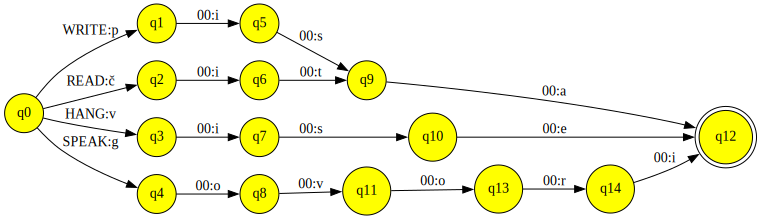

In [2]:
VstemVstr = '''[[SPEAK .x. {govori}] |
[WRITE .x. {pisa}] | 
[READ .x. {čita}] |
[HANG .x. {vise}] ]
'''
VstemV = hfst.regex(VstemVstr)
VstemV.view()

Compare this from the original Fst program.
```
define VstemV [ [SPEAK .x. {govori}] |
                [WRITE .x. {pisa}] |
                [READ .x. {čita}] |
                [HANG .x. {vise}] ];
```

In [3]:
VstemCstr = '''[[LOUNGE .x. {bred}] | [GUARD .x. {bereg}] |
     [ROW .x. {greb}] |
     [STEAL .x. {krad}] |
     [ PLACE .x. {klad}] |
     [ CRAWL .x. {lez}] |
     [ BEABLE .x. {mog}] |
     [ SWEEP .x. {met}] |
     [ CARRY .x. {nes}] |
     [ FIND .x. {obret}] |
     [ PLAIT .x. {plet}] |
     [ BAKE .x. {pek}] |
     [ HERD .x. {pas}] |
     [ SCRAPE .x. {skreb}] |
     [ THRASH .x. {sek}]]
'''
VstemC = hfst.regex(VstemCstr)
Vstem = VstemV.copy()
Vstem.disjunct(VstemC)

This is the Fst equivalent.
```
VstemUp = Vstem.u;
```

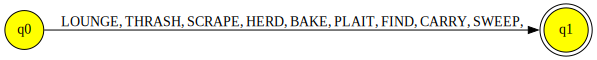

In [4]:
VStemUp = Vstem.copy()
VStemUp.input_project()
VStemUp.minimize()
VStemUp.view()

In [5]:
print(random.sample(set(VStemUp.extract_paths(max_cycles=3).keys()),10))

['THRASH', 'CRAWL', 'HANG', 'PLAIT', 'SCRAPE', 'SWEEP', 'FIND', 'BEABLE', 'BAKE', 'STEAL']


In [6]:
def sample_input(x,n=8,cycles=3):
        x2 = x.copy()
        x2.input_project()
        x2.minimize()
        return(random.sample(set(x2.extract_paths(max_cycles=3).keys()),n))


In [7]:
sample_input(Vstem)

['SPEAK', 'PLACE', 'BEABLE', 'THRASH', 'CARRY', 'HANG', 'WRITE', 'GUARD']

This is similar in Fst.
```
regex Vstem.u;
print random-words
```

In [8]:
def sample_output(x,n=8,cycles=3):
        x2 = x.copy()
        x2.output_project()
        x2.minimize()
        return(random.sample(set(x2.extract_paths(max_cycles=3).keys()),n))

In [9]:
sample_output(Vstem)

['čita', 'nes', 'obret', 'bereg', 'met', 'klad', 'plet', 'sek']

```
regex Vstem.l;
print random-words
```

## Inflections and morphological words

In [10]:
Infl_str = "MasPst : l | [[FemPst : 0] 0:l 0:a]"
Infl = hfst.regex(Infl_str)

In [11]:
PHRASE = Vstem.copy()
PHRASE.input_project()
separator = hfst.regex('"+":0')
separator_up = separator.copy()
separator_up.input_project()
Infl_up = Infl.copy()
Infl_up.input_project()
PHRASE.concatenate(separator_up)
PHRASE.concatenate(Infl_up)

In [12]:
sample_output(PHRASE)

['WRITE+MasPst',
 'HERD+FemPst',
 'PLAIT+FemPst',
 'ROW+FemPst',
 'CARRY+MasPst',
 'PLACE+FemPst',
 'GUARD+MasPst',
 'PLAIT+MasPst']

## Morphological spelling relation

In [13]:
M = Vstem.copy()
M.disjunct(separator)
M.disjunct(Infl)
MOR = M.copy()
MOR.repeat_plus()

This isn't constrained to underling words on the input side. Do do that, compose with `PHRASE`.

In [14]:
x = PHRASE.copy()
x.compose(MOR)
sample_input(x)

['HERD+MasPst',
 'GUARD+FemPst',
 'BAKE+FemPst',
 'LOUNGE+MasPst',
 'SPEAK+FemPst',
 'WRITE+FemPst',
 'CRAWL+FemPst',
 'SCRAPE+FemPst']

In [15]:
sample_output(x)

['pletl', 'kladla', 'visela', 'metla', 'pisal', 'pletla', 'visel', 'pisala']

The above are underlying spellings. 

In [16]:
def unspell(u): 
    um = hfst.regex(" ".join([x for x in u]))
    result = PHRASE.copy()
    result.compose(MOR)
    result.compose(um)
    result.input_project()
    result.minimize()
    return(list(result.extract_paths(max_cycles=3).keys()))
    

In [17]:
unspell('skrebl')

['SCRAPE+MasPst']

In [18]:
unspell('pisala')

['WRITE+FemPst']

In [19]:
unspell('himom')

[]

## Three phonological rules

### LDrop
Delete `l` word finally.

C = b | č | d | k | g | l | m | n | p | r | s | t | t' | v | z;

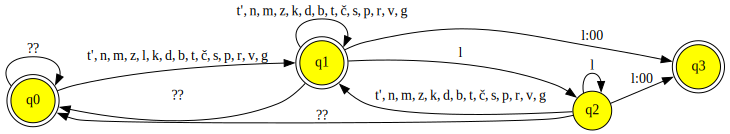

In [20]:
LDrop = hfst.regex("l -> 0 || b | č | d | k | g | l | m | n | p | r | s | t | t' | v | z _ .#.")
LDrop.view()

#### Dental stop deletion 
Define DSD, a phonological rule which deletes dental stops before `l`.

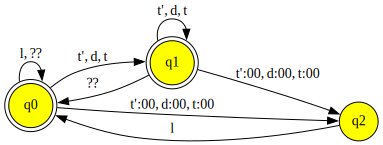

In [21]:
DSD = hfst.regex("[t | d | t'] -> 0 || _ l;")
DSD.view()

#### Devoi
Devoice `b,d,g,z` word-finally.

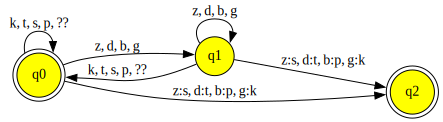

In [22]:
Devoi = hfst.regex("b -> p, d -> t, g -> k, z -> s || _ .#.")
Devoi.view()

In [23]:
def apply_rules(u,rs):
    m = hfst.regex(" ".join([x for x in u]))
    print(list(m.extract_paths(max_cycles=3).keys())[0])
    for r in rs:
        m.compose(r)
        m.output_project()
        m.minimize()
        print(list(m.extract_paths(max_cycles=3).keys())[0])

In [24]:
apply_rules('skrebl',[LDrop])

skrebl
skreb


In [25]:
apply_rules('skrebl',[LDrop,Devoi])

skrebl
skreb
skrep


## Compose the Phonology
```
define PHON DSD .o. LDrop .o. Devoi;
```

In [26]:
PHON = DSD.copy()
PHON.compose(LDrop)
PHON.compose(Devoi)

In [27]:
apply_rules('skrebl',[DSD,LDrop,Devoi])

skrebl
skrebl
skreb
skrep


In [28]:
apply_rules('skrebl',[PHON])

skrebl
skrep


*This example is made up.*

In [29]:
apply_rules('skrebtl',[DSD,LDrop,Devoi])

skrebtl
skrebl
skreb
skrep


In [30]:
apply_rules('skrebtl',[PHON])

skrebtl
skrep


## Compose the finite state lexicon
```
define Russian PHRASE .o. MOR .o. PHON;
```

In [31]:
Russian = PHRASE.copy()
Russian.compose(MOR)
Russian.compose(PHON)
Russian.minimize()

In [32]:
# Russian.view()
sample_input(Russian)

['BAKE+FemPst',
 'WRITE+MasPst',
 'STEAL+FemPst',
 'READ+MasPst',
 'THRASH+MasPst',
 'BEABLE+MasPst',
 'PLACE+MasPst',
 'CARRY+FemPst']

In [ ]:
sample_output(Russian)

In [ ]:
def parse(u,Lexicon): 
    um = hfst.regex(" ".join([x for x in u]))
    inv = Lexicon.copy()
    inv.invert()
    um.compose(inv)
    um.output_project()
    um.minimize()
    return(list(um.extract_paths(max_cycles=3).keys()))

In [ ]:
parse('skrep',Russian)

In [ ]:
parse('pisala',Russian)

In [ ]:
separator_up.view()

In [ ]:
def generate(stem,inflection,Lexicon):
    u = hfst.regex(stem)
    infl = hfst.regex(inflection)
    sep = hfst.regex('"+"')
    u.concatenate(sep)
    u.concatenate(infl)
    u.compose(Lexicon)
    u.output_project()
    u.minimize()
    return(list(u.extract_paths(max_cycles=3).keys()))

In [ ]:
generate('LOUNGE','FemPst',Russian)

In [ ]:
generate('SCRAPE','MasPst',Russian)

In [ ]:
surface = Russian.copy()
surface.output_project()
surface.minimize()
surface_word = list(surface.extract_paths(max_cycles=3).keys())
for w in surface_word:
    u = parse(w,Russian)
    print(f"{w} {u}")

 

## Definitional style

In [ ]:
Cons = hfst.regex("b | č | d | k | g | l | m | n | p | r | s | t | t' | v | z")

This is probably incomplete.

In [ ]:
Vowel = hfst.regex("e | a | i")

In [ ]:
defs = {"C":Cons,"V":Vowel}

In [ ]:
cvc = hfst.regex("C V C", definitions=defs)
cvc.minimize()
sample_output(cvc)

#### Cleaner Ldrop

In [ ]:
LDrop = hfst.regex("l -> 0 || C _ .#.", definitions=defs)

In [ ]:
defs.keys()

#### Cleaner Phonology

In [ ]:
defs['DSD'] = DSD
defs['LDrop'] = LDrop
defs['Devoi'] = Devoi
defs.keys()

In [ ]:
PHON2 = hfst.regex('DSD .o. LDrop .o. Devoi', definitions=defs)
PHON2.minimize()

In [ ]:
apply_rules('skrebl',[DSD,LDrop,Devoi])

In [ ]:
apply_rules('skrebl',[PHON2])

```
Russian = PHRASE.copy()
Russian.compose(MOR)
Russian.compose(PHON)
Russian.minimize()
```

In [ ]:
defs['PHRASE'] = PHRASE
defs['MOR'] = MOR
defs.keys()

In [ ]:
Russian2 = hfst.regex('PHRASE .o. MOR .o. PHON2', definitions=defs)